In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

dataset_zip = zipfile.ZipFile('/content/drive/MyDrive/fruit-disease-split.zip', 'r')
dataset_zip.extractall()
dataset_zip.close()

In [3]:
%cd /content/fruit-disease-split/

/content/fruit-disease-split


In [4]:
! ls

test  train  val


In [5]:
import os

base_dir = '/content/fruit-disease-split/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [6]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(224, 224))

Found 1036 images belonging to 8 classes.


In [8]:
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(224, 224))

Found 131 images belonging to 8 classes.


In [9]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(224, 224))

Found 135 images belonging to 8 classes.


In [10]:
base_model = tf.keras.applications.MobileNet(weights='imagenet',
                                             include_top=False,
                                             input_shape=(224, 224, 3))

17225924/17225924 [==============================] - 0s 0us/step


In [11]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(8, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False


model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [12]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=10,
                               verbose=1,
                               restore_best_weights=True)

history = model.fit(train_generator,
                    epochs=50,
                    validation_data=validation_generator,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/50
33/33 [==============================] - 14s 167ms/step - loss: 2.3208 - accuracy: 0.3234 - val_loss: 1.2717 - val_accuracy: 0.6031
Epoch 2/50
33/33 [==============================] - 5s 159ms/step - loss: 1.0320 - accuracy: 0.6612 - val_loss: 0.9504 - val_accuracy: 0.6641
Epoch 3/50
33/33 [==============================] - 4s 133ms/step - loss: 0.7500 - accuracy: 0.7703 - val_loss: 0.7876 - val_accuracy: 0.7099
Epoch 4/50
33/33 [==============================] - 5s 162ms/step - loss: 0.6311 - accuracy: 0.7876 - val_loss: 0.6738 - val_accuracy: 0.7710
Epoch 5/50
33/33 [==============================] - 5s 136ms/step - loss: 0.4894 - accuracy: 0.8359 - val_loss: 0.6081 - val_accuracy: 0.7863
Epoch 6/50
33/33 [==============================] - 5s 163ms/step - loss: 0.4383 - accuracy: 0.8610 - val_loss: 0.5485 - val_accuracy: 0.8244
Epoch 7/50
33/33 [==============================] - 4s 132ms/step - loss: 0.3759 - accuracy: 0.8784 - val_loss: 0.5013 - val_accuracy: 0.8321
Epoch

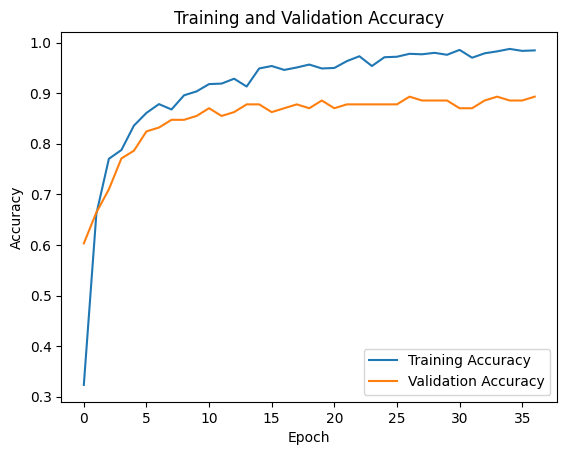

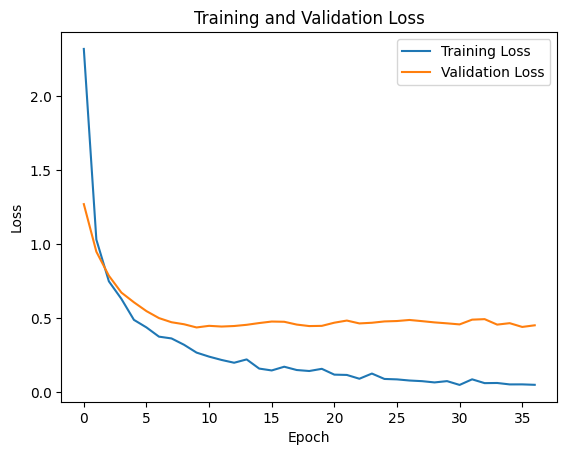

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 1s 1s/step
Predicted class: Apple_Scab
Confidence: 99.92%


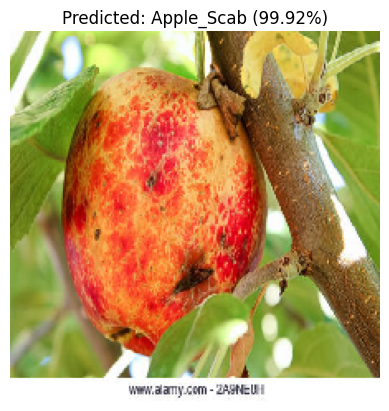

In [15]:
import numpy as np
from keras.preprocessing import image

def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

def predict_image(model, img_path, class_indices):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class = list(class_indices.keys())[predicted_class_index]
    confidence = predictions[0][predicted_class_index] * 100
    return predicted_class, confidence

img_path = '/content/fruit-disease-split/test/Apple_Scab/2a9ne8h.jpg'
class_indices = train_generator.class_indices

predicted_class, confidence = predict_image(model, img_path, class_indices)

print(f'Predicted class: {predicted_class}')
print(f'Confidence: {confidence:.2f}%')

img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.title(f'Predicted: {predicted_class} ({confidence:.2f}%)')
plt.axis('off')
plt.show()

In [17]:
model.save('Fruit_Disease.h5')